# Proyecto final de imágenes
## EL5206-2 Laboratorio de inteligencia computacional y robótica
### **Integrantes:**
### Benjamín Castro
### Melanie Peña
### **Auxiliar:**
### Jorge Zambrano
### **Profesor:**
### Carlos Navarro



#### Imports de las librerías y archivos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import skimage.feature as feature
import tensorflow
import pandas as pd
from pathlib import Path

# Se usa el modelo pre-entrenado VGG-16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# Arregla el error de la función imshow (en caso que sea necesaria)
from google.colab.patches import cv2_imshow

In [2]:
# JPG1
if not Path("jpg1.tar.gz").is_file():
  !wget "ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz"

--2022-11-29 20:17:05--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz
           => ‘jpg1.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg1.tar.gz ... 1141827194
==> PASV ... done.    ==> RETR jpg1.tar.gz ... done.
Length: 1141827194 (1.1G) (unauthoritative)

jpg1.tar.gz         100%[===================>]   1.06G  7.37MB/s    in 3m 19s  

2022-11-29 20:20:25 (5.47 MB/s) - ‘jpg1.tar.gz’ saved [1141827194]



In [3]:
# JPG2
if not Path("jpg2.tar.gz").is_file():
  !wget "ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz"

--2022-11-29 20:20:51--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz
           => ‘jpg2.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg2.tar.gz ... 1701364177
==> PASV ... done.    ==> RETR jpg2.tar.gz ... done.
Length: 1701364177 (1.6G) (unauthoritative)

jpg2.tar.gz         100%[===================>]   1.58G  8.76MB/s    in 3m 32s  

2022-11-29 20:24:24 (7.66 MB/s) - ‘jpg2.tar.gz’ saved [1701364177]



###IMPORTAR DE DRIVE (ALTERNATIVA)

In [5]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/JPG

/content/drive/MyDrive/JPG


In [7]:
# Extrae los archivos tar.gz
!tar -xf jpg1.tar.gz
!tar -xf jpg2.tar.gz 

### 1. *Feature Extraction*

#### CNN

In [8]:
# Extracción con VGG-16
model = VGG16(weights='imagenet',include_top=False)

def feat_cnn(net,img):
  """ Toma el modelo con el cual predecir y la ID la imagen en string,
  devuelve el vector de características """
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  path = './jpg/'+img+'.jpg' # Ruta de acceso de la base de datos
  img_loaded = image.load_img(path, target_size = (224,224))
  x = image.img_to_array(img_loaded)
  x = np.expand_dims(x,axis=0)
  x = preprocess_input(x)
  feat = net.predict(x)
  return feat

58889256/58889256 [==============================] - 0s 0us/step


#### LBP 

In [9]:
def feat_lbp(img):
  """ Toma la ID de imagen en string, devuelve el vector de características"""
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  path = './jpg/'+img+'.jpg' # Ruta de acceso de la base de datos
  img_loaded = image.load_img(path, color_mode = "grayscale", target_size = (224,224))
  # Cantidad de píxeles de radio a considerar
  r = 1
  p = 8
  lbp_img = feature.local_binary_pattern(img_loaded, P = p, R = r)
  (hist, _) = np.histogram(lbp_img.ravel(), bins = np.arange(0, 84), range = (0,255))

  # Normalización
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-6)
  
  return hist


In [10]:
def feat_extract(img,ext):
  """ Toma dos strings: nombre de la imagen y tipo de extracción,
  se puede escoger clásico o usando CNN"""
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  assert ext == 'classic' or ext == 'cnn','Puede escoger solo cnn o classic'
  if ext == 'classic':
    return feat_lbp(img)
  if ext == 'cnn':
    return feat_cnn(model,img)

### 2. Medida de similitud

In [11]:
def cos_dist(x1,x2):
  """ Toma la distancia entre 2 vectores """
  norm1 = np.linalg.norm(x1)
  norm2 = np.linalg.norm(x2)
  if norm1 == 0.0 or norm2 == 0.0:
    return 0.0
  else:
    num = np.sum(x1*x2)
    den = np.sqrt(norm1)*np.sqrt(norm2)
    return num/den

In [12]:
def euclidean(x1,x2):
  return np.linalg.norm(x1-x2)

#### Guardar las características de cada imagen de la base de datos 

##### Imágenes de consulta

In [15]:
def numtostr(num,dig):
  ''' Función que pasa de un entero a string dependiendo de 
  si se trata de ID (2 dig.) oclase (3 dig.) '''
  assert type(num) is int,'Ingrese un valor entero'
  # Func. auxiliar que retorna el valor entero con cierta ctdad de ceros
  def entero(num,nozeros=0):
    return nozeros*'0' + str(num)
  num = abs(num)
  if dig == 'ID':
    if num in range(0,10):
      return entero(num,1)
    else:
      return entero(num)
  if dig == 'class':
    if num in range(0,10):
      return entero(num,2)
    if num in range(10,100):
      return entero(num,1)
    else:
      return entero(num)


In [16]:
# Lista con nombres de imágenes de consulta:
path_query = ['1'+numtostr(n,'class')+'00' for n in range(0,500)]

##### Imágenes base de datos

In [17]:
# Almacena los nombres de las imagenes de las bases de datos
path_db = []
for i in range(0,500):
  for j in range(1,11):
    # Revisa si existe el archivo con ese nombre
    path = '1'+numtostr(i,'class')+numtostr(j,'ID')
    if Path("./jpg/"+path+'.jpg').is_file():
      path_db.append(path) # Lo guarda

### SI TIENE LOS ARCHIVOS .npy, NO EJECUTAR 

In [ ]:
# Vectores característicos de imágenes de consulta 
# se almacenan en la lista
query_cnn = []
query_classic = []
for i in range(0,500):
  query_cnn.append(feat_extract(path_query[i],'cnn'))
  query_classic.append(feat_extract(path_query[i],'classic'))

1/1 [==============================] - 0s 430ms/step


In [ ]:
# La información se guarda en diccionarios para consultar
query_cnn_DB = dict(zip(path_query,query_cnn))
query_classic_DB = dict(zip(path_query,query_classic)) 

In [ ]:
# Guarda en archivos npy los vectores característicos
np.save('q_cnn.npy', query_cnn_DB)
np.save('q_classic.npy', query_classic_DB)

In [ ]:
db_cnn = []
db_classic = []
for path in path_db:
  db_cnn.append(feat_extract(path,'cnn'))
  db_classic.append(feat_extract(path,'classic'))

1/1 [==============================] - 0s 406ms/step


In [ ]:
# La información se guarda en diccionarios para consultar
db_cnn_dict = dict(zip(path_db,db_cnn))
db_classic_dict = dict(zip(path_db,db_classic)) 

In [ ]:
# Guarda en archivos npy los vectores característicos
np.save('db_cnn.npy', db_cnn_dict)
np.save('db_classic.npy', db_classic_dict)

### 3. Ordenar resultados por relevancia

#### Carga de diccionarios

In [18]:
query_cnn_DB = np.load('q_cnn.npy',allow_pickle = True, )
query_classic_DB = np.load('q_classic.npy',allow_pickle = True)

In [19]:
db_cnn_dict = np.load('db_cnn.npy',allow_pickle = True)
db_classic_dict = np.load('db_classic.npy',allow_pickle = True)

In [20]:
def distances(img,mode):
  ''' Toma el string de la imagen de consulta y calcula las
  distancias con respecto a los features de la base de datos 
  (diccionario 'data') '''
  assert type(img) is str and img in path_query and type(mode) is str,'Ingrese el nombre\
  de una imagen de consulta (string) y un modo válido'
  dist = []
  if mode == 'cnn':
    for path in path_db:
      # Calcula la distancia euclideana entre los vectores de feature
      query = query_cnn_DB.item().get(img)
      database = db_cnn_dict.item().get(path) 
      d = euclidean(query,database)
      dist.append(d)
  if mode == 'classic':
    for path in path_db:
      query = query_classic_DB.item().get(img)
      database = db_classic_dict.item().get(path) 
      d = euclidean(query,database)
      dist.append(d)
  # DataFrame que almacena las distancias de los feature
  df = pd.DataFrame()
  df['Image'] = path_db
  df['Distance'] = dist
  df.sort_values(by = ['Distance'], ascending = True, inplace=True)
  df = df.reset_index(drop=True)
  return df


In [21]:
distances('100100','cnn')

,Image,Distance
0,100101,585.681030
1,134702,974.160461
2,135101,978.471313
3,135002,984.080261
4,135103,986.174622
...,...,...
983,138304,2672.898438
984,134003,2757.203369
985,100601,2871.819824
986,109001,2965.712158


In [22]:
def nrel(img):
  i = 0
  for image in path_db:
    if image[0:4] == img[0:4]:
      i +=1
  return i

In [23]:
def ranking(img,mode):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']]
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  rank = sum(dist.index.tolist())/nrel(img)
  return rank

In [24]:
ranking('134500','cnn')

79.5

In [25]:
def rank_norm(img,mode):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']] 
  N = dist['Image'].count()
  Nrel = nrel(img)
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  ind = dist.index.tolist()
  idx = [index - Nrel*(Nrel+1)/2 for index in ind] 
  return sum(idx)*(1/(N*Nrel))

In [26]:
distances('142400','cnn')

,Image,Distance
0,125801,825.011108
1,125802,829.866577
2,133602,833.995667
3,147501,845.831055
4,124801,847.476562
...,...,...
983,138304,2632.303955
984,134003,2719.075684
985,100601,2826.456787
986,109001,2921.387939


In [29]:
rank_norm('134500','cnn')

0.07034412955465587

In [30]:
distances('142400','classic')[0:10]

,Image,Distance
0,108106,0.037192
1,138501,0.038068
2,132301,0.039815
3,138102,0.040709
4,142301,0.040985
5,129201,0.040986
6,140001,0.041108
7,134901,0.041164
8,125301,0.041933
9,138305,0.042765


In [31]:
def results(img,mode):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode)[0:10]
  dist = dist.loc[:,['Image']].to_numpy()
  for path in dist:
    path = './jpg/'+str(path[0])+'.jpg' # Ruta de acceso de la base de datos
    image = cv2.imread(path)
    image = cv2.resize(image,(224,224))
    cv2_imshow(image)


#### Ejemplo de Búsqueda

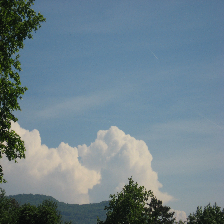

In [37]:
i = cv2.imread('./jpg/134600.jpg')
i = cv2.resize(i,(224,224))
cv2_imshow(i)

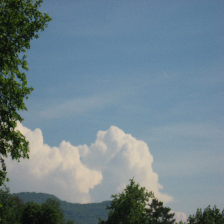

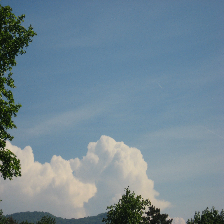

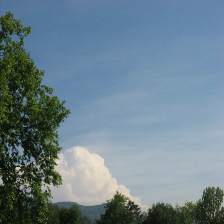

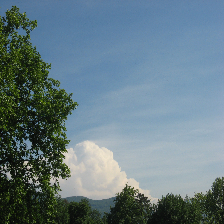

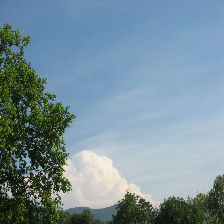

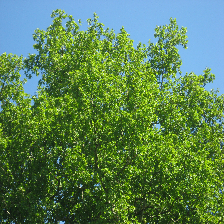

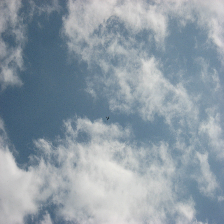

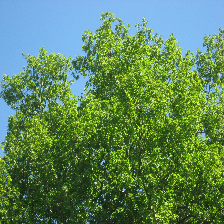

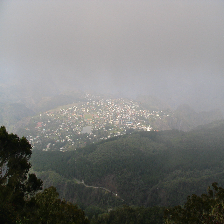

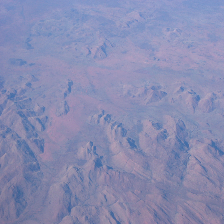

In [38]:
results('134600','cnn')

## Uso de *clustering* : **K-means**

In [54]:
# Import del método
from sklearn.cluster import KMeans
from skimage.color import rgb2gray

img1 = cv2.imread('./jpg/134600.jpg')
X = img1.reshape((-1, 1))
k_means = KMeans(n_clusters=2)
k_means.fit(X)

KMeans(n_clusters=2)

In [53]:
k_means.labels_.shape

(17842176,)

In [78]:
def cluster_k(img):
  '''Calcula el vector característico de imagen usando
  clustering (K-Means) '''
  assert type(img) is str 
  path = './jpg/'+img+'.jpg' # Ruta de acceso de la base de datos
  img_loaded = cv2.imread(path)
  img_loaded = cv2.resize(img_loaded,(224,224))
  x = img_loaded.reshape((-1,1))
  k_means = KMeans(n_clusters=8,random_state=0)
  k_means.fit(x)
  x_clustered = k_means.labels_
  return x_clustered

### NO CORRER A MENOS QUE TENGA LOS ARCHIVOS

In [79]:
cluster_db = []
for path in path_db:
  cluster_db.append(cluster_k(path))

In [80]:
cluster_query = []
for path in path_query:
  cluster_query.append(cluster_k(path))

In [81]:
# La información se guarda en diccionarios para consultar
cluster_q_dict = dict(zip(path_query,cluster_query))
cluster_db_dict = dict(zip(path_db,cluster_db)) 

In [82]:
# Guarda en archivos npy los vectores característicos
np.save('cluster_q.npy', cluster_q_dict)
np.save('cluster_db.npy', cluster_db_dict)

### Correr si ya tiene los archivos listos

In [83]:
# Cargar archivos
cluster_q_DB = np.load('cluster_q.npy',allow_pickle = True, )
cluster_db_DB = np.load('cluster_db.npy',allow_pickle = True)

In [88]:
def distances_cluster(img):
  ''' Toma el string de la imagen de consulta y calcula las
  distancias con respecto a los features de la base de datos 
  (diccionario 'data') '''
  assert type(img) is str and img in path_query,'Ingrese el nombre\
  de una imagen de consulta (string)'
  dist = []
  
  # Calcula la distancia euclidena entre los vectores caracteristicos
  # de cada imagen de la base de datos
  for path in path_db:
    query = cluster_q_DB.item().get(img)
    database = cluster_db_DB.item().get(path) 
    d = euclidean(query,database)
    dist.append(d)
  
  # DataFrame que almacena las distancias de los vectores
  df = pd.DataFrame()
  df['Image'] = path_db
  df['Distance'] = dist
  df.sort_values(by = ['Distance'], ascending = True, inplace=True)
  df = df.reset_index(drop=True)
  return df


In [89]:
distances_cluster('100000')

,Image,Distance
0,104201,987.540885
1,115801,1002.232009
2,135901,1006.640452
3,136009,1012.827231
4,136008,1019.458680
...,...,...
983,139003,1542.440274
984,103203,1560.285551
985,128701,1588.140737
986,133003,1597.960262


In [90]:
def rank_norm_cluster(img):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances_cluster(img) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']] 
  N = dist['Image'].count()
  Nrel = nrel(img)
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  ind = dist.index.tolist()
  idx = [index - Nrel*(Nrel+1)/2 for index in ind] 
  return sum(idx)*(1/(N*Nrel))

In [105]:
rank_norm_cluster('145500')

0.6401821862348178

In [94]:
def results_cluster(img):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances_cluster(img)[0:10]
  dist = dist.loc[:,['Image']].to_numpy()
  for path in dist:
    path = './jpg/'+str(path[0])+'.jpg' # Ruta de acceso de la base de datos
    image = cv2.imread(path)
    image = cv2.resize(image,(224,224))
    cv2_imshow(image)

#### Ejemplo de búsqueda con *clustering*

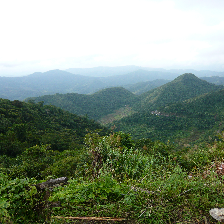

In [108]:
i = cv2.imread('./jpg/100000.jpg')
i = cv2.resize(i,(224,224))
cv2_imshow(i)

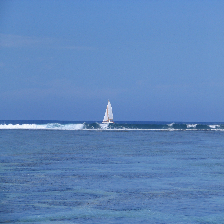

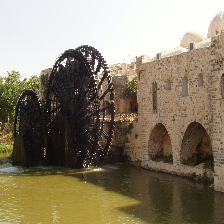

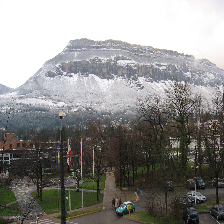

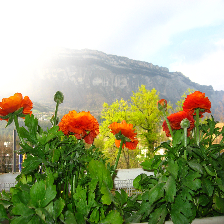

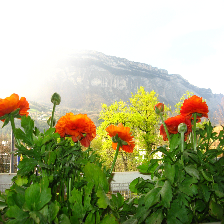

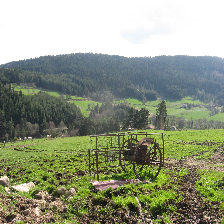

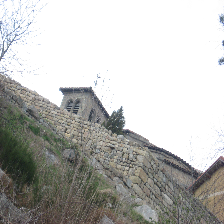

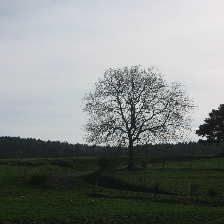

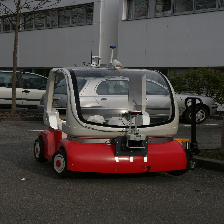

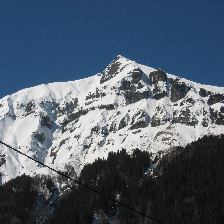

In [109]:
results_cluster('100000')